In [1]:
import numpy as np
from skimage.io import imread
from tqdm import tqdm
import glob, os, dxchange, svmbir
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp 


olefile module not found


In [1]:
# parameters used for data cleaning
"""
if_clean: switch of cleaning operation (bool)
if_save_clean: switch of saving cleaned tiff files (bool)
low_gate: the lower index of the image hist bin edges (int 0-9)
high_gate: the higher index of the image hist bin edges (int 0-9)
correct_radius: the neighbors (2r+1 * 2r+1 matrix) radius used for replacing bad pixels (int) 
"""
clean_paras = {'if_clean': True, 'if_save_clean': True, 'low_gate': 1, 'high_gate': 9, 'correct_radius': 1}

In [2]:
# pre-processing
"""
DataCleaner Class: find the abnormal pixels (extremely low/high) and replaced by median value of the neighor matrix
===========
to initiate cleaner: 
data_cleaner = DataCleaner(clean_paras, clean_path)
[clean_paras]: parameters used for cleaning (dictionary)
[clean_path]: the directory where save the cleaned data (if save) and logs (strings)
===========
to clean a 2D image:
cleaned_data = data_cleaner(orginal_im, save_file_name)
[original_im]: the image need to be cleaned (M*M array)
[save_file_name]: the cleaned tiff and its log will be saved in this name (strings)

"""

class DataCleaner(object): 
    def __init__(self, paras, clean_path):
        # for clean data
        self.low_gate = paras['low_gate']
        self.high_gate = paras['high_gate']
        self.r = paras['correct_radius']
        self.CLEAN = paras['if_clean']
        self.SAVE_CLEAN = paras['if_save_clean']
        self.clean_path = clean_path
        
    def run(self, im, fname):
        self.im = im
        self.row, self.col = self.im.shape
        self.corr_im = np.nan_to_num(self.im.copy(), nan=0, posinf=0, neginf=0)
        self.log = {}
        self.fname = fname

        if self.CLEAN:
            self.replace_pix()
            self.save_opt()

    def replace_pix(self):
        hist, bin_edges = np.histogram(self.corr_im.flatten(), density=False)
        thres_low = bin_edges[self.low_gate]
        thres_high = bin_edges[self.high_gate]
        x_coords, y_coords = np.nonzero(np.logical_or(self.corr_im <= thres_low, self.corr_im > thres_high))
        r = self.r

        org_val, cor_val = [], []
        for x, y in zip(x_coords, y_coords):
            X_, _X = max(0, x-r), min(self.corr_im.shape[0], x+r)
            Y_, _Y = max(0, y-r), min(self.corr_im.shape[1], y+r)
            org_val.append(self.corr_im[x, y])
            pat = self.im[X_ : _X+1, Y_: _Y+1]
            if np.nonzero(pat > thres_low)[0].size >=4:
                _elements = list(pat.flatten())
                _elements.pop(r*(1+2*r)+r)
                _corrected = np.median(_elements)#sum(_elements)/(pat.size-1)
                self.corr_im[x, y] = _corrected
                cor_val.append(_corrected)
            else:
                print('ERROR, too many zeros around pixel({},{})'.format(x, y))
                cor_val.append('-')
        
        self.log = {'fname': self.fname, 'X': x_coords, 'Y': y_coords, 
                    'original': org_val, 'corrected': cor_val}
        
    def save_opt(self):
        if self.SAVE_CLEAN:
            tif_fld = os.path.join(self.clean_path,'clean_tiff')
            os.makedirs(tif_fld, exist_ok=True)

            _fname = os.path.join(tif_fld, f'ZeroRemove_{self.fname}')
            dxchange.writer.write_tiff(self.corr_im, fname=_fname, overwrite=True)

        log_fld = os.path.join(self.clean_path, 'logs')
        os.makedirs(log_fld, exist_ok=True)
        
        df = pd.DataFrame.from_dict(self.log, orient='columns')
        log_name = os.path.join(log_fld, f'clean_log_{self.fname}.csv')
        df.to_csv(log_name)
        
        print(f'save log into {log_name}')


In [3]:
def worker(fl):
    return (imread(fl).astype(np.float32)).swapaxes(0,1)

def hype_loader_sum(fls_lst):
    with mp.Pool(processes=10) as pool:
        data = pool.map(worker, fls_lst)

    return np.array(data).sum(axis=0)[10:-10, 10:-10]

In [118]:
# load a open beam
fld_path = ('/SNS/VENUS/IPTS-33699/shared/processed_data/'
            'September26_2024_PurpleCar_OpenBean_5_0_C_Cd_inBeam_Resonance')
flds = glob.glob(os.path.join(fld_path, 'Run*')) # find all projections
flds.sort()

angle_list_file = os.path.join(fld_path, 'list_angles.txt')
df = pd.read_csv(angle_list_file, header=None)

run_num = df.iloc[:, 0].to_list()
p_charge_ob = df.iloc[:, 2].to_numpy()

ob = []
for fld, p_cg in tqdm(zip(flds, p_charge_ob)):
    fls_lst = glob.glob(os.path.join(fld, '*.tif*'))
    fls_lst.sort()
    ob.append(hype_loader_sum(fls_lst)/p_cg*5) 
ob_data = np.array(ob, dtype=np.float32)
OB = ob_data.sum(axis=0)/len(flds)


5it [00:39,  7.94s/it]


In [119]:
fname = '/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD_OB/combined/open_bean_5C_run '
dxchange.writer.write_tiff_stack(ob_data, fname=fname, dtype=np.float32, 
                                 axis=0, digit=5, start=3221, overwrite=True)

In [85]:
# initialize cleaner
data_cleaner = DataCleaner(clean_paras, 
                           clean_path='/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD_OB')

In [86]:
data_cleaner.run(OB, 'Run_OB_avg')
OB_clean = data_cleaner.corr_im

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD_OB/logs/clean_log_Run_OB_avg.csv


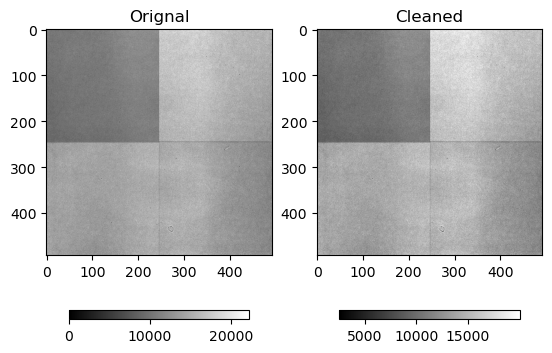

In [87]:
fig, axs = plt.subplots(1,2, dpi = 100)
#"""
pcm0 = axs[0].imshow(OB, cmap='gray')
axs[0].set_title('Orignal')
fig.colorbar(pcm0, ax=axs[0], shrink=0.8, orientation = 'horizontal')
#"""

pcm1 = axs[1].imshow(OB_clean, cmap='gray')
axs[1].set_title('Cleaned')
fig.colorbar(pcm1, ax=axs[1], shrink=0.8, orientation = 'horizontal')

In [9]:
# load a data
fld_path = ('/SNS/VENUS/IPTS-33699/shared/processed_data/'
            'September20_2024_PurpleCar_GoldenRatio_CT_5_0_C_Cd_inBeam_Resonance')
flds = glob.glob(os.path.join(fld_path, 'Run*')) # find all projections
flds.sort()

In [10]:
projs = []
for fld in tqdm(flds):
    fls_lst = glob.glob(os.path.join(fld, '*.tif*'))
    fls_lst.sort()
    projs.append(hype_loader_sum(fls_lst))

hype_data = np.array(projs, dtype = np.float32)

100%|██████████| 82/82 [09:44<00:00,  7.13s/it]


In [12]:
fname = '/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/combined/gd_ratio_CT'
dxchange.writer.write_tiff_stack(hype_data, fname=fname, dtype=np.float32, 
                                 axis=0, digit=5, start=0, overwrite=True)

In [5]:
fld_path = ('/SNS/VENUS/IPTS-33699/shared/processed_data/'
            'September20_2024_PurpleCar_GoldenRatio_CT_5_0_C_Cd_inBeam_Resonance')
angle_list_file = os.path.join(fld_path, 'list_angles.txt')
df = pd.read_csv(angle_list_file, header=None)
angle_deg = df.iloc[:, 1].to_numpy()
run_num = df.iloc[:, 0].to_list()
p_charge = df.iloc[:, 2].to_numpy()

In [58]:
run_num

['Run_3032',
 'Run_3033',
 'Run_3034',
 'Run_3035',
 'Run_3036',
 'Run_3037',
 'Run_3038',
 'Run_3039',
 'Run_3040',
 'Run_3041',
 'Run_3042',
 'Run_3141',
 'Run_3142',
 'Run_3143',
 'Run_3144',
 'Run_3145',
 'Run_3146',
 'Run_3147',
 'Run_3148',
 'Run_3149',
 'Run_3150',
 'Run_3151',
 'Run_3152',
 'Run_3153',
 'Run_3154',
 'Run_3155',
 'Run_3156',
 'Run_3157',
 'Run_3158',
 'Run_3159',
 'Run_3160',
 'Run_3161',
 'Run_3162',
 'Run_3163',
 'Run_3164',
 'Run_3165',
 'Run_3166',
 'Run_3167',
 'Run_3168',
 'Run_3169',
 'Run_3170',
 'Run_3171',
 'Run_3176',
 'Run_3177',
 'Run_3178',
 'Run_3179',
 'Run_3180',
 'Run_3181',
 'Run_3182',
 'Run_3183',
 'Run_3184',
 'Run_3185',
 'Run_3186',
 'Run_3187',
 'Run_3188',
 'Run_3189',
 'Run_3192',
 'Run_3193',
 'Run_3194',
 'Run_3196',
 'Run_3197',
 'Run_3198',
 'Run_3199',
 'Run_3200',
 'Run_3201',
 'Run_3202',
 'Run_3203',
 'Run_3204',
 'Run_3205',
 'Run_3206',
 'Run_3207',
 'Run_3208',
 'Run_3209',
 'Run_3210',
 'Run_3211',
 'Run_3212',
 'Run_3213',

In [14]:
# initialize cleaner
data_cleaner = DataCleaner(clean_paras, clean_path='/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD')

In [15]:
# clean the data
clean_data = []
for im, rnum in tqdm(zip(hype_data, run_num)):
    data_cleaner.run(im, rnum)
    clean_data.append(data_cleaner.corr_im)
    clean_log = data_cleaner.log

clean_hype = np.array(clean_data, dtype = np.float32)

2it [00:00, 15.72it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3032.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3033.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3034.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3035.csv


8it [00:00, 20.80it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3036.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3037.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3038.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3039.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3040.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3041.csv


15it [00:00, 24.42it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3042.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3141.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3142.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3143.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3144.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3145.csv


21it [00:00, 23.35it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3146.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3147.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3148.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3149.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3150.csv


27it [00:01, 24.32it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3151.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3152.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3153.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3154.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3155.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3156.csv


33it [00:01, 24.59it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3157.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3158.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3159.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3160.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3161.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3162.csv


39it [00:01, 25.12it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3163.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3164.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3165.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3166.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3167.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3168.csv


42it [00:01, 22.91it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3169.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3170.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3171.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3176.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3177.csv


48it [00:02, 22.48it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3178.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3179.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3180.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3181.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3182.csv


54it [00:02, 22.78it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3183.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3184.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3185.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3186.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3187.csv


60it [00:02, 24.36it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3188.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3189.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3192.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3193.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3194.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3196.csv


63it [00:02, 21.44it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3197.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3198.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3199.csv


66it [00:02, 18.29it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3200.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3201.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3202.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3203.csv


69it [00:03, 18.68it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3204.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3205.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3206.csv


74it [00:03, 20.14it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3207.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3208.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3209.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3210.csv


77it [00:03, 18.70it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3211.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3212.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3213.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3214.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3215.csv


82it [00:03, 21.98it/s]

save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3216.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3217.csv
save log into /SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/logs/clean_log_Run_3218.csv


In [2]:
# Load from clean save
clean_path = '/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD/clean_tiff'
fls_lst = glob.glob(os.path.join(clean_path, '*.tif*'))
fls_lst.sort()

_data = []
for fl in fls_lst:
    _data.append(imread(fl).astype(np.float32))

clean_data = np.array(_data, dtype = np.float32)

In [29]:
clean_data.shape

(82, 492, 492)

In [3]:
clean_path = '/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_GD_OB/clean_tiff'
fls_lst = glob.glob(os.path.join(clean_path, '*avg.tif*'))
fls_lst.sort()

_data = []
for fl in fls_lst:
    _data.append(imread(fl).astype(np.float32))

OB_clean= np.array(_data[0], dtype = np.float32)

In [6]:
#sino, angle_rad = svmbir.sino_sort(hype_data, np.deg2rad(angle_deg))
sino_clean, angle_rad = svmbir.sino_sort(clean_data/p_charge[..., np.newaxis, np.newaxis]*5, 
                                         np.deg2rad(angle_deg))

In [42]:
sino_clean.shape

(82, 492, 492)

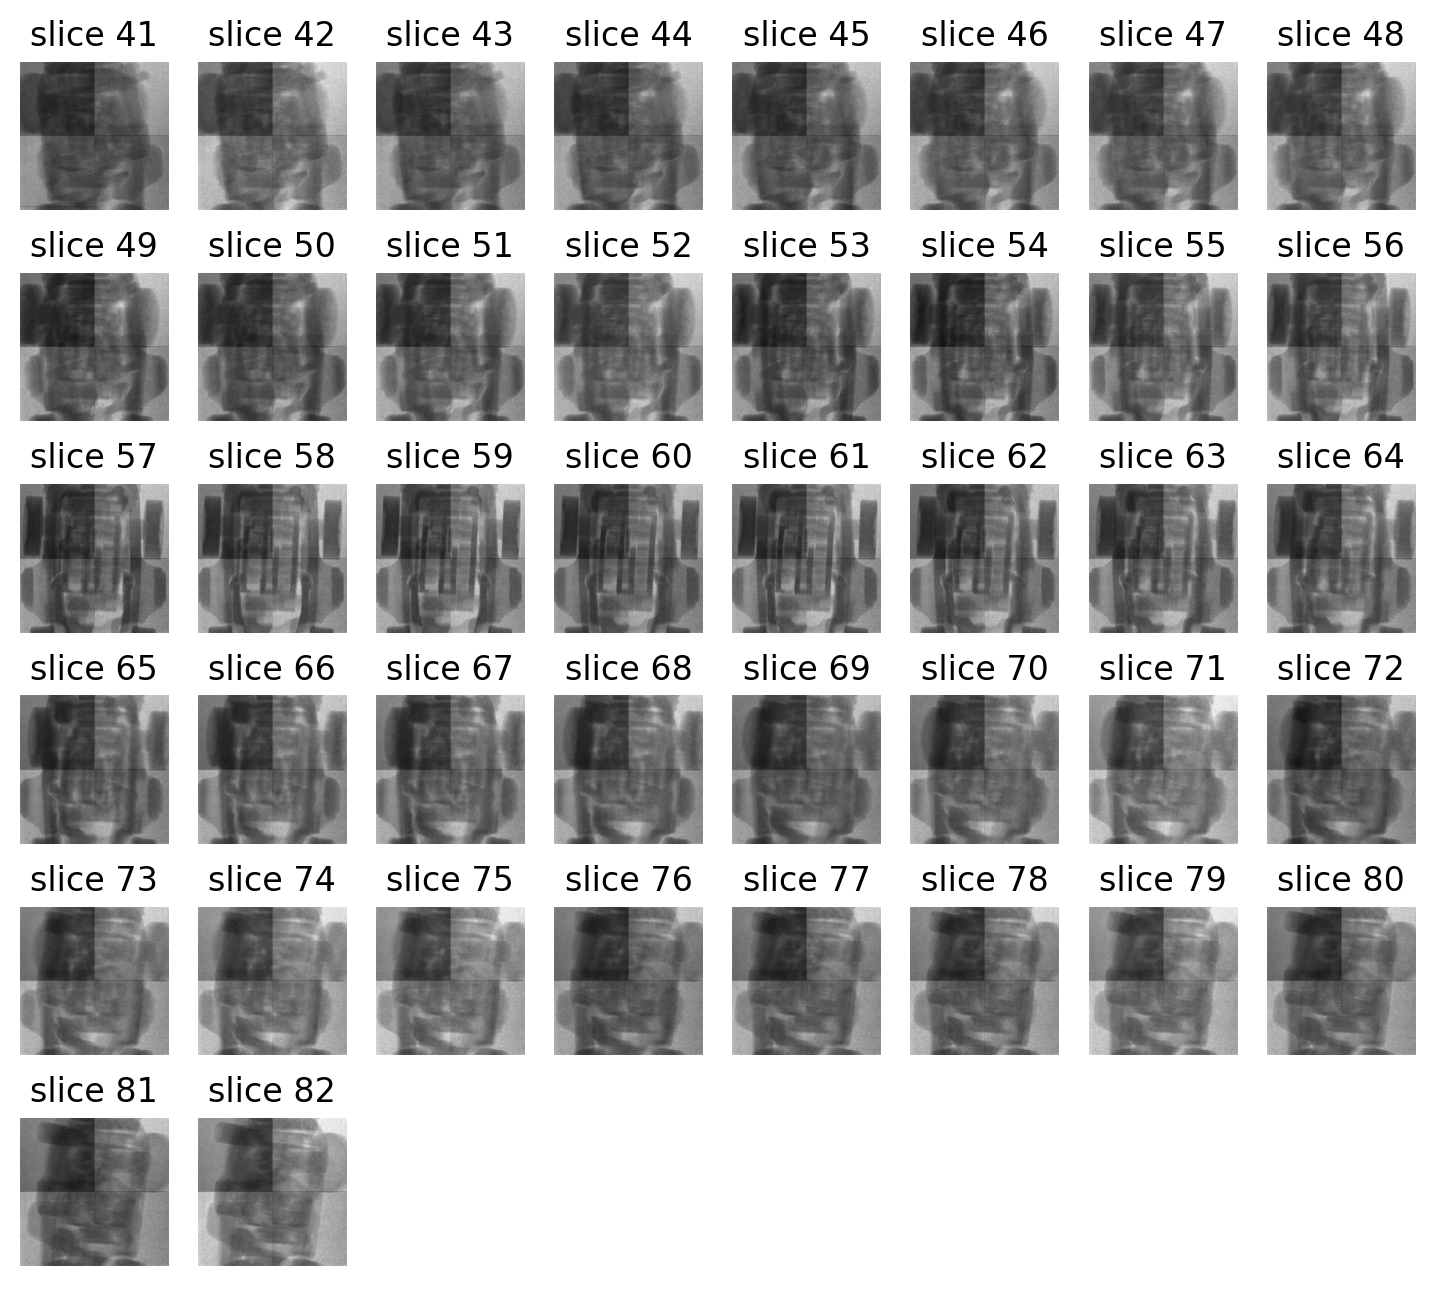

In [56]:
fig, axs = plt.subplots(6,8, figsize = (9, 8), dpi = 200)
"""
pcm0 = axs[0].imshow(hype_data[45], cmap='gray')
axs[0].set_title('Orignal')
fig.colorbar(pcm0, ax=axs[0], shrink=0.8, orientation = 'horizontal')
"""
cnt = 40
for ax in (axs.flat):
    if cnt>81:
        ax.set_axis_off() 
    else:
        pcm1 = ax.imshow(sino_clean[cnt], cmap='gray')
        ax.set_title(f'slice {cnt+1}')
        ax.set_axis_off() 
        #fig.colorbar(pcm1, ax=ax, shrink=0.8, orientation = 'horizontal')
    
    cnt+=1


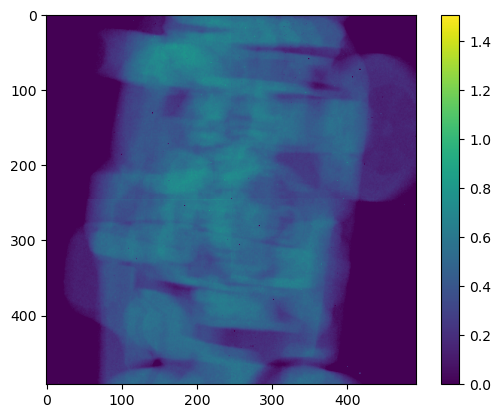

In [9]:
# normalization proj/p_charge*5   ob/p_charge*5
norm_data = -np.log(sino_clean/OB_clean)
plt.imshow(norm_data[80], vmin = 0)
plt.colorbar()

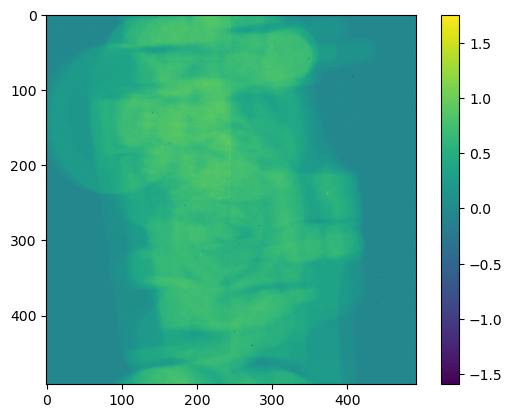

In [21]:
plt.imshow(norm_data[30],)
plt.colorbar()

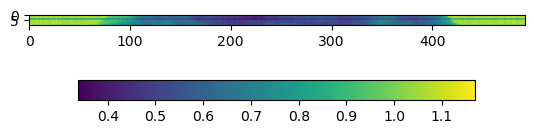

In [20]:
plt.imshow((sino_clean/OB_clean)[25:35, 246])
plt.colorbar(orientation = 'horizontal', shrink=0.8)

In [40]:
# chips correction
def correct_alignment(im, paras, fill_gap=True):
    """
    Function to correct alignment of the 4 segments in each image caused by the mismatch between the 4 chips.
    Orginal @ Samin, revised for data shape (height x width)
    Args:
        unaligned_image(ndarray): 2D projection data ( height x width)
        offsets(list): a list of offset values along X and Y axis, respectively (X offset, Y offset) [2, 2]
        center(list,optional): X and Y coordinate of the center that is connected to all 4 chips
        fill_gap(bool,optional): true/false, the function will fill the gap after moving the chips according to the
            offsets if set to true
        num_pix_unused(int,optional): number of pixels along the border not to be used while filling the gap
        num_pix_neighbor(int,optional): number of neighboring pixels used for filling the gap
        
    Returns:
        ndarray: aligned projection data 
    """
    row, col = im.shape
    x_offset = paras['x_off']
    y_offset = paras['y_off']
    center_x = paras['cent_x'] 
    center_y = paras['cent_y']
    num_pix_unused = paras['unused_pix_num']
    num_pix_neighbor  = paras['neighbor_pix_num']
    
    # Get the center
    if center_x is not None:
        # Check if the unaligned image contains the alignemnt center along both axes
        if (center_x < 0) or (center_x > row):
            center_x = row // 2
            x_offset = 0
        if (center_y < 0) or (center_y > col):
            center_y = col // 2
            y_offset = 0
    else:
        center_x = row // 2
        center_y = col // 2
        
    # Return the original image if both the offset values are zero
    if (x_offset == 0) and (y_offset == 0):
        print("correct_alignment() Warning: Alignment correction not performed as both the offset values are zero.")

    # Get the chips
    chip_1 = im[:center_x, :center_y]
    chip_2 = im[:center_x, center_y:]
    chip_3 = im[center_x:, :center_y]
    chip_4 = im[center_x:, center_y:]

    # Move the chips and create aligned image
    moved_image = np.zeros((row + x_offset,  col + y_offset,))

    moved_image[:center_x, :center_y] = chip_1
    moved_image[:center_x, center_y + y_offset:] = chip_2
    moved_image[center_x + x_offset:, :center_y] = chip_3
    moved_image[center_x + x_offset:, center_y + y_offset:] = chip_4

    if fill_gap is True:
        filled_image = np.copy(moved_image)

        # Fill gaps along row-axis
        if x_offset > 0:
            x_upper_bound = row - num_pix_unused - num_pix_neighbor
            x_lower_bound = num_pix_unused + num_pix_neighbor
            if x_upper_bound > center_x >= x_lower_bound:
                x0_up = center_x - num_pix_unused - num_pix_neighbor
                x1_up = center_x - num_pix_unused
                region_up = np.expand_dims(np.mean(filled_image[x0_up:x1_up], axis=0), axis=0)

                x0_down = center_x + x_offset + num_pix_unused
                x1_down = center_x + x_offset + num_pix_unused + num_pix_neighbor
                region_down = np.expand_dims(np.mean(filled_image[x0_down:x1_down], axis=0), axis=0)

                weights_x = np.expand_dims(np.linspace(0, 1, x_offset + 2 * num_pix_unused), axis=1)
                filled_image[center_x - num_pix_unused:center_x + x_offset + num_pix_unused] = np.matmul(
                    weights_x[::-1], region_up) + np.matmul(weights_x, region_down)
            else:
                print("correct_alignment() Warning: Couldn't fill gaps along y-axis as the center is close to border.")

        # Fill gaps along col-axis
        if y_offset > 0:
            y_upper_bound = col - num_pix_unused - num_pix_neighbor
            y_lower_bound = num_pix_unused + num_pix_neighbor
            if y_upper_bound > center_y >= y_lower_bound:
                y0_left = center_y - num_pix_unused - num_pix_neighbor
                y1_left = center_y - num_pix_unused
                region_left = np.expand_dims(np.mean(filled_image[:, y0_left:y1_left], axis=1), axis=1)

                y0_right = center_y + y_offset + num_pix_unused
                y1_right = center_y + y_offset + num_pix_unused + num_pix_neighbor
                region_right = np.expand_dims(np.mean(filled_image[:, y0_right:y1_right], axis=1), axis=1)

                weights_y = np.expand_dims(np.linspace(0, 1, x_offset + 2 * num_pix_unused), axis=0)
                filled_image[:, center_y - num_pix_unused:center_y + y_offset + num_pix_unused] = np.matmul(
                    region_left, weights_y[:, ::-1]) + np.matmul(region_right, weights_y)
            else:
                print("correct_alignment() Warning: Couldn't fill gaps along x-axis as the center is close to border.")

        return filled_image

    else:
        return moved_image

In [96]:
# for alignment chips
align_paras = {'x_off': 2, 'y_off': 2, 'cent_x': 246, 'cent_y': 246, 'unused_pix_num': 1, 'neighbor_pix_num': 3}
_aligned = []
for im in norm_data:
    _aligned.append(correct_alignment(im, align_paras))

aligned_data = np.array(_aligned, dtype=np.float32)

In [97]:
# calculate center of rotation
import tomopy
rot_center_est = tomopy.find_center_pc(np.squeeze(aligned_data[0,:,]), 
                                       np.squeeze(aligned_data[-1,:,]), 
                                       tol=0.5)
print('rotation center is {}'.format(rot_center_est))

rotation center is 241.0


In [110]:
# calculate tilt correction and apply it
_sino = tomopy.remove_stripe_fw(aligned_data,level=6,ncore=10)

In [135]:
# launch svmbir
center_offset = -6#-(492/2 - rot_center_est)
num_threads = 24
max_iterations = 200

T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0

recon = svmbir.recon(sino = _sino[:, :100], angles=angle_rad,
                     num_rows = 494, num_cols = 494,
                     center_offset = center_offset, sharpness=sharpness,
                     snr_db = snr_db, positivity= True, 
                     max_iterations = max_iterations, num_threads= num_threads, 
                     verbose=0, svmbir_lib_path = '/storage',)

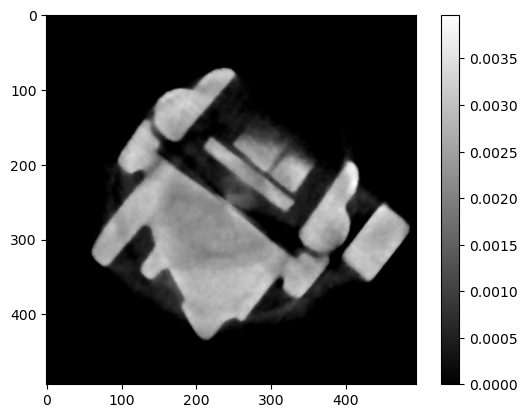

In [136]:
plt.imshow(recon[50], cmap='gray', )
plt.colorbar()

In [137]:
fname = '/SNS/VENUS/IPTS-33699/shared/Shimin_save/Purple_car_inBean_recon/recon_slice'
dxchange.writer.write_tiff_stack(recon, fname=fname, dtype=np.float32, 
                                 axis=0, digit=5, start=0, overwrite=True)